# Extreme precipitation: Examples on how to carry out a climate risk assessment
Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEAVY_RAINFALL/main?labpath=EXTREME_PRECIPITATION_Risk_Assessment_examples.ipynb) to launch this notebook on MyBinder.</br>
Click [![Heavy Rainfall](https://img.shields.io/badge/HEAVY_RAINFALL-repository-blue)](https://github.com/CLIMAAX/HEAVY_RAINFALL/tree/main) to go to this workflow's GitHub repository.

## Examples of how to develop a risk assessment

In this section, you can check real-world examples on how to carry out a risk assessment following the guidelines presented in this workflow. Feel free to explore the code and modify it according to your specific needs. 

### List of examples:
1. [Are rainfall warning levels ready for climate change? A case study in Catalonia, Spain](#example-1-are-rainfall-warning-levels-ready-for-climate-change-a-case-study-in-catalonia-spain)
2. [More to come! Keep an eye on this section for new updates and examples](#example-2-more-to-come-keep-an-eye-on-this-section-for-new-updates-and-examples)



## Prepare your workspace
:::{admonition} Find out about the Python libraries we will use in this notebook.
:class: hint dropdown

* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data.
* [osmnx](https://osmnx.readthedocs.io/en/stable/) - A Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
* [matplotlib](https://matplotlib.org/stable/) -  A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [contextily](https://contextily.readthedocs.io/en/latest/) - To retrieve matplotlib compatible tile maps from the internet.
* [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) - A Python interface to PROJ (cartographic projections and coordinate transformations library).
* [geopandas](https://geopandas.org/en/stable/) - extends the datatypes used by pandas to allow spatial operations on geometric types.

### Load libraries

In [1]:
# Libraries to download data and manage files
import os
import glob
import osmnx
import pooch

# Libraries for numerical computations, array manipulation and statistics.
import xarray as xr
import pandas as pd
import numpy as np

# Libraries to handle geospatial data
import rioxarray as rio
import geopandas as gpd
from shapely import box
import pyproj
import rasterio

# Libraries to plot maps, charts and tables
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx

# Choosing the matplotlib backend
%matplotlib inline

## Example 1: Are rainfall warning levels ready for climate change? A case study in Catalonia, Spain

The region of Catalonia is located in the northest part of Spain. Due to enhanced convective rainfall events located over the mountainous coastal basins, Catalonia is highly vulnerable to extreme rainfall events that are concentrated between September and May. These events are becoming more frequent, with some resulting in severe urban floods with numerous casualties and significant socio-economic damages. For instance, the storm Gloria in 2020 caused widespread flooding across Catalonia, leaving extensive damage, casualties and more than 500 evacuations. Several areas recorded more than 180 mm of rainfall in 24 hours during the storm, beating historical records all over the region.

To increase the preparedness and response of the region, the Meteorological Service of Catalonia (SMC) issues warnings for [Dangerous Meteorological Situations](https://www.meteo.cat/wpweb/divulgacio/la-prediccio-meteorologica/situacio-meteorologica-de-perill/) due to rainfall using two critical thresholds:
1. Low risk: 100 mm/ 24 hours
2. High risk: 200 mm/ 24 hours

These have been defined based on regional studies in the Catalonia region. However, considering the increased frequency of extreme precipitation events, the impacts associated with these and the number of triggered warnings per year, the regional authorities are interested in exploring how these current official thresholds could vary due to the influence of climate change.

The objective of this risk assessment is to evaluate how these critical rainfall thresholds defined by the SMC vary in the context of climate scenarios. The results can provide officials with valuable insights into the frequency shifts of these extreme events and the magnitude of changes that could be expected. This information is key for informed decision-making and enhancing preparedness measures to mitigate the impacts of climate change.

### Step 1: Select your analysis area
For this risk assessment, two analyses will be made:

1. A specific location: We will focus on the city of Blanes, located in the province of Girona. Blanes has experienced extreme precipitation events in the past, including the recent storm Gloria mentioned earlier
2. Regional assessment: We will zoom out our analysis to cover the entire Catalonia region. This extended scope will provide insights into the overall impact of extreme precipitation across Catalonia


In [2]:
bbox = [0, 40.2, 3.3, 43.5]; areaname = 'Catalonia'

### Setting your directory structure
The next cell will create the *extreme_precipitation_risk* folder in the directory where the notebook is saved. You can change the absolute path defined in the variable ```workflow_dir``` to create it elsewhere.

In [3]:
# Define the path for the extreme_precipitation_risk folder.
workflow_dir = 'extreme_precipitation_risk'
# workflow_dir = 'flashflood_workflow'
# Create the directory checking if it already exists.
os.makedirs(workflow_dir, exist_ok=True)

Now, we will create a subfolder for general data as well as specific subfolders to save data for our area of interest, plots generated by the code and new datasets computed within the workflow.

In [4]:
# Define directories for general data.
general_data_dir = os.path.join(workflow_dir, 'general_data')
# Define specific directories for the selected area
data_dir = os.path.join(workflow_dir, f'data_{areaname}')
results_dir = os.path.join(workflow_dir, f'results_{areaname}')
plots_dir = os.path.join(workflow_dir, f'plots_{areaname}')

# Create the directories checking if they already exist.
os.makedirs(general_data_dir, exist_ok = True)
os.makedirs(data_dir, exist_ok = True)
os.makedirs(results_dir, exist_ok = True)
os.makedirs(plots_dir, exist_ok = True)

We also need to define the path of the *extreme_precipitation_hazard* folder in order to access the files previously downloaded and created in the _Hazard Assessment_ notebook.

In [5]:
# Define the hazard directory
hazard_dir = 'extreme_precipitation_hazard'
# Define the subfolder's paths
hazard_general_data_dir = os.path.join(hazard_dir, 'general_data')
hazard_data_dir = os.path.join(hazard_dir, f'data_{areaname}')
hazard_results_dir = os.path.join(hazard_dir, f'results_{areaname}')

### Prepare access to the ready-to-go pree-calculated European datasets

Load the file registry for the `precipitation_idf_gcm_eur` dataset in the CLIMAAX cloud storage with pooch.

If any files requested below were downloaded before, pooch will inspect the local file contents and skip the download if the contents match expectations.

In [6]:
precip_data_pooch = pooch.create(
    path=general_data_dir,
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/precipitation_idf_gcm_eur/"
)
precip_data_pooch.load_registry("files_registry.txt")

### Step 2: Calculate or identify your critical impact-based rainfall thresholds

As mentioned above, the two critical rainfall thresholds identified are: 
1. Low risk: 100 mm/ 24 hours
2. High risk: 200 mm/ 24 hours
Where the frequency/return period of these thresholds varies across the Catalonia region. The local data used for this analysis is publicly provided by the SMC [here](https://www.meteo.cat/wpweb/climatologia/dades-i-productes-climatics/corbes-idf/idf-mapes/).

For the city of Blanes, the critical impact-based rainfall threshold has been defined as 100 mm/24 hours for a 5-year return period.


### Step 3: Load the Hazard data
To carry out our risk assessment, we will use the hazard dataset generated by executing the code in the [Hazard Assessment](EXTREME_PRECIPITATION_Hazard_Assessment.ipynb) Notebook (Catalonia example). Thus, we will define the ```DATASET_HAZARD_ASSESSMENT``` as True. Our analysis will compare the baseline (observations) to the period of 2041-2070. 
For more details on how the hazard dataset used in this risk assessment was generated, please refer to the [Hazard Assessment](EXTREME_PRECIPITATION_Hazard_Assessment.ipynb#step-1-download-the-euro-cordex-from-the-climate-data-store). Additionally, you can find information on the pre-calculated hazard datasets in the Hazard section of this workflow.



:::{note}
**If you're using the ready-to-go pre-calculated European datasets, make sure to define the ```DATASET_HAZARD_ASSESSMENT``` as False** and check for the available combinations of the Global Circulation Model (GCM) and Representative Concentration Pathways (RCP) provided in the hazard section. Once you've downloaded these from the pre-calculated datasets, we'll slice them to our area of interest defined in lat/lon coordinates in the bounding box and save the new files in the data directory of the Risk Assessment notebook for easy access later on
:::


In [7]:
# Define global variable to define the dataset to use (False to use pre-computed datasets)
DATASET_HAZARD_ASSESSMENT = False

# Define global options for hazard dataset (matching the ones in Hazard Assessment or within the pre-computed dataset options)
GCM = 'ichec-ec-earth'
RCP = 'rcp85'

# Select which time-frames and durations within the available you want to study (Check for options above) or choose the ones computed in the Hazard Assessment.
TIME_FRAMES = {
    'historical' :'1976-2005',
    RCP : '2041-2070' 
}

# Define durations to read/download
DURATIONS = [3, 24]

# Dictionary of hazard dataset path's (filled automatically with the information of above)
HAZARD_PATHS = {}

In [8]:
# (if needed) Download pre-calculated European datasets
if not DATASET_HAZARD_ASSESSMENT:
    # Download all files for the selected GCM
    for path in precip_data_pooch.registry:
        if path.startswith(GCM):
            precip_data_pooch.fetch(path)

# Fill the HAZARD_PATHS dictionary and (if needed) slice the european datasets to the area of interest 
for dur in DURATIONS:
    HAZARD_PATHS[dur] = {}
    for run, years in TIME_FRAMES.items():
        if DATASET_HAZARD_ASSESSMENT:
            HAZARD_PATHS[dur][run] = os.path.join(hazard_results_dir, f'idf_{dur}h_{GCM}_{run}_{years}.nc')

        else:
            path = glob.glob(os.path.join(general_data_dir, GCM, run, f'idf_{dur}h*_{years}.nc'))[0]
            path_out = os.path.join(data_dir, os.path.basename(path))
            if not os.path.exists(path_out):
                with xr.open_dataset(path, decode_cf = True) as ds:
                    # Cut bounding box area
                    # Reproject usual coordinates (in WGS84) to EURO-CORDEX's CRS.
                    CRS = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
                    transformer = pyproj.Transformer.from_crs('epsg:4326',CRS)
                    West, South, East, North = bbox
                    rlon_min, rlat_min, rlon_max, rlat_max = transformer.transform_bounds(South, West, North, East)
                    # slice European dataset to area of region using boundig box.
                    ds = ds.sel(rlat = slice(rlat_min, rlat_max), rlon = slice(rlon_min, rlon_max))
                    # Save in data_dir directory for further use
                    ds.to_netcdf(path_out)
            HAZARD_PATHS[dur][run] = path_out

### Step 4: Specify your critical impact-based rainfall thresholds

To carry our risk assessment, let's specify the critical impact-based rainfall thresholds for both Blanes and Catalonia. We will define these in terms of **M**agnitude, **D**uration and **F**requency.

**Keep in mind:** The code below helps us translate and link our real-world data to the climate dataset projections we're using in this workflow (non-biased corrected EURO-CORDEX). This step is necessary for improving the robustness of our analysis with the climate projections.


In [9]:
def magnitude_frequency_shift(thresh_param, ds_baseline, ds_horizon):
    """ Returns the new magnitudes and frequencies of given threshold under climate change.

        thresh_param : list with the 3 elements of critical threshold [intensity, duration, frequency]
        ds_baseline : dataarray of expected precipitation of the baseline period. DataArray index is expected to be
                        just 'return_period'.
        ds_horizon : same specifications as ds_baseline for future horizon (e.g. 2070)
    """
    # Threshold parameters
    th_int, th_dur, th_freq = thresh_param

    # Access data (return_periods and values for baseline and future)
    ret_per_bs = ds_baseline.return_period.values
    ret_per_proj = ds_horizon.return_period.values
    prec_bs = ds_baseline.values
    prec_proj = ds_horizon.values

    # Translation of threshold into baseline eurocordex (interpolation of precipitation vs. log(return periods)).
    prec_base_aux = np.interp(np.log(th_freq), np.log(ret_per_bs), prec_bs)

    ### Change in frequency
    # Get new frequency by interpolation
    shift_ret_per = np.interp(prec_base_aux, prec_proj, np.log(ret_per_proj))
    shift_ret_per = np.ceil(np.exp(shift_ret_per))

    ### Change in magnitude using proxy of baseline.
    # Get new precipitation by interpolation
    prec_proj_aux = np.interp(np.log(th_freq), np.log(ret_per_proj), prec_proj)
    factor_prec = prec_proj_aux/prec_base_aux
    shift_prec = th_int * factor_prec

    # Rounding values to 2 decimals.
    shift_prec = round(shift_prec, 2)
    factor_prec = round(factor_prec, 2)

    return shift_ret_per, shift_prec, factor_prec

#### For a specific-site: Blanes city, Catalonia

In [10]:
# Define the parameters of your threshold.
INTENSITY_TH = 100     # in mm
DURATION_TH = 24       # in hours
FREQUENCY_TH = 5       # in years

# Lat/lon coordinates for Blanes locality.
POINT = [41.674, 2.792]

In [11]:
# Transform POINT to Hazard dataset reference system
CRS = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326', CRS)
rpoint = transformer.transform(POINT[0], POINT[1])

# Read historical IDF for point
ds_hist = xr.open_dataset(HAZARD_PATHS[DURATION_TH]['historical'], decode_cf=True)
ds_hist = ds_hist.sel(rlat = rpoint[1], rlon = rpoint[0], duration=DURATION_TH, method = 'nearest', drop=True).idf

# Read future IDF for point
ds_proj = xr.open_dataset(HAZARD_PATHS[DURATION_TH][RCP], decode_cf=True)
ds_proj = ds_proj.sel(rlat = rpoint[1], rlon = rpoint[0], duration=DURATION_TH, method='nearest', drop=True).idf

# Apply function to poing
shift_point = magnitude_frequency_shift([INTENSITY_TH, DURATION_TH, FREQUENCY_TH], ds_hist, ds_proj); del ds_hist, ds_proj

#### For the entire region of Catalonia

In [12]:
def linear_extrapolation(x_points, y_points, x, nodata=None):
    # nodata
    if np.any(x_points == nodata):
        return nodata
    # Left extrapolation
    if x < x_points[0]:
        slope = (y_points[1] - y_points[0]) / (x_points[1] - x_points[0])
        return max(1e-10, y_points[0] + slope * (x - x_points[0]))
   # Right extrapolation
    elif x > x_points[-1]:
        slope = (y_points[-1] - y_points[-2]) / (x_points[-1] - x_points[-2])
        return y_points[-1] + slope * (x - x_points[-1])
    # Normal interpolation
    else:
        return np.interp(x, x_points, y_points)


# TODO: ERIKA
Descripción IDFs


In [13]:
# Read all IDFs
rp = [2, 5, 10, 20, 50, 100, 200, 500]
list_files = sorted(glob.glob("/var/dades/research1/gonzalez/CLIMAAX/ECMWF_GITHUB/data/CLIMA_IDF2020_*.tif"))
# Get metadata
meta = rasterio.open(list_files[0]).meta
# Read data
idf_cat = np.zeros((len(rp), meta['height'], meta['width']))
for i, f in enumerate(list_files):
    idf_cat[i, :, :] = rasterio.open(f).read(1)

# Do the interpolation to get the RP for the 100mm
ds_rp_th = np.apply_along_axis(linear_extrapolation, 0, idf_cat, rp, INTENSITY_TH, nodata=meta['nodata'])

# Save the RP tiff
path_rp_th = os.path.join(results_dir, 'RP_CAT_threshold_100mm.tiff')
with rasterio.open(path_rp_th, 'w', **meta) as dst:
        dst.write(ds_rp_th, 1)

In [15]:
# Load and plot the return period for critical threshold.
print("Loading Catalonia thresholds...")
ds_rp_th = rio.open_rasterio(path_rp_th)
nodata = rasterio.open(list_files[0]).meta['nodata']

# Access projection and data values
proj_rp_th = ds_rp_th.rio.crs
transform_rp_rh = ds_rp_th.rio.transform()
nvar, ny, nx = ds_rp_th.shape
data = ds_rp_th.values

# Create new arrays for return period shift, precipitation shift and precipitation factor.
sh_rp = np.full((ny,nx), fill_value=ds_rp_th._FillValue, dtype='float64')
sh_prec = np.full((ny,nx), fill_value=ds_rp_th._FillValue, dtype='float64')
sh_prec_factor = np.full((ny, nx), fill_value=ds_rp_th._FillValue, dtype='float64')

# Transform lat/lon coordinates into Hazard Dataset CRS.
xy_th = np.asarray(np.where(data > 0))[[2,1],:]
trans_th_haz = pyproj.Transformer.from_crs(proj_rp_th, CRS)
lonlat_th = np.asarray(trans_th_haz.transform(ds_rp_th.x[xy_th[0]], ds_rp_th.y[xy_th[1]]))

# Read historical and future datasets
ds_hist = xr.open_dataset(HAZARD_PATHS[DURATION_TH]['historical'], decode_cf=True)
ds_future = xr.open_dataset(HAZARD_PATHS[DURATION_TH][RCP], decode_cf=True)

# Loop over each pixel to compute transformation
for i in range(len(xy_th[0])):
    th_rp_i = ds_rp_th.isel(x = xy_th[0, i], y = xy_th[1, i]).values[0]
    data_hist = ds_hist.idf.sel(rlon = lonlat_th[0,i], rlat = lonlat_th[1,i], method='nearest').sel(duration=DURATION_TH)
    data_future = ds_future.idf.sel(rlon = lonlat_th[0,i], rlat = lonlat_th[1,i], method='nearest').sel(duration=DURATION_TH)

    # Calling shift function
    shift = magnitude_frequency_shift([INTENSITY_TH, DURATION_TH, th_rp_i], data_hist, data_future)
    sh_rp[xy_th[1, i], xy_th[0, i]] = shift[0]
    sh_prec[xy_th[1, i], xy_th[0, i]] = shift[1]
    sh_prec_factor[xy_th[1, i], xy_th[0, i]] = shift[2]

Loading Catalonia thresholds...


In [16]:
def write_geotiff(filename, data):
    path_tiff = os.path.join(results_dir, filename)
    with rasterio.open(
        path_tiff,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype='float64',
        crs=proj_rp_th.to_wkt(),
        nodata=ds_rp_th._FillValue,
        transform=transform_rp_rh,
        tiled=True,
        copy_src_overviews=True,
        compress='DEFLATE',
        predictor=3
    ) as dst:
        dst.write(data, 1)
        
# Save each variable as GeoTIFF in results directory.
filename_rp = f"RP_shift_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_rp, sh_rp)

filename_prec = f"PREC_shift_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_prec, sh_prec)

filename_factor = f"PREC_factor_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_factor, sh_prec_factor)


### Step 5: Let’s explore our results!
As a quick reminder, the objective of this risk assessment is to explore how the current critical impact-based rainfall thresholds will vary in terms of frequency and magnitude. In other words, we want to understand how rainfall patterns might change in the future while either maintaining the current frequency or magnitude of our critical thresholds.


#### For a specific-site: Blanes city
In the case of Blanes (a specific location), we can print the results using the code below:


In [17]:
print(f"For the period of {TIME_FRAMES[RCP]}, the critical impact-based rainfall threshold of {INTENSITY_TH} mm/{DURATION_TH} hours, associated with a {FREQUENCY_TH}-year return period:")
print(f"   * If we want to maintain the same frequency (return period), the magnitude will vary by {(shift[2]-1)*100:.2f} % from the current threshold")
print(f"   * If we want to maintain the same magnitude, the frequency (return period) will change from {FREQUENCY_TH} to {shift_point[0]} years.")

For the period of 2041-2070, the critical impact-based rainfall threshold of 100 mm/24 hours, associated with a 5-year return period:
   * If we want to maintain the same frequency (return period), the magnitude will vary by 18.00 % from the current threshold
   * If we want to maintain the same magnitude, the frequency (return period) will change from 5 to 3.0 years.


#### For the entire region of Catalonia
We can create some visualisations to better understand the changes in Magnitude and Frequency of our critical thresholds for the period of 2041-2070. 


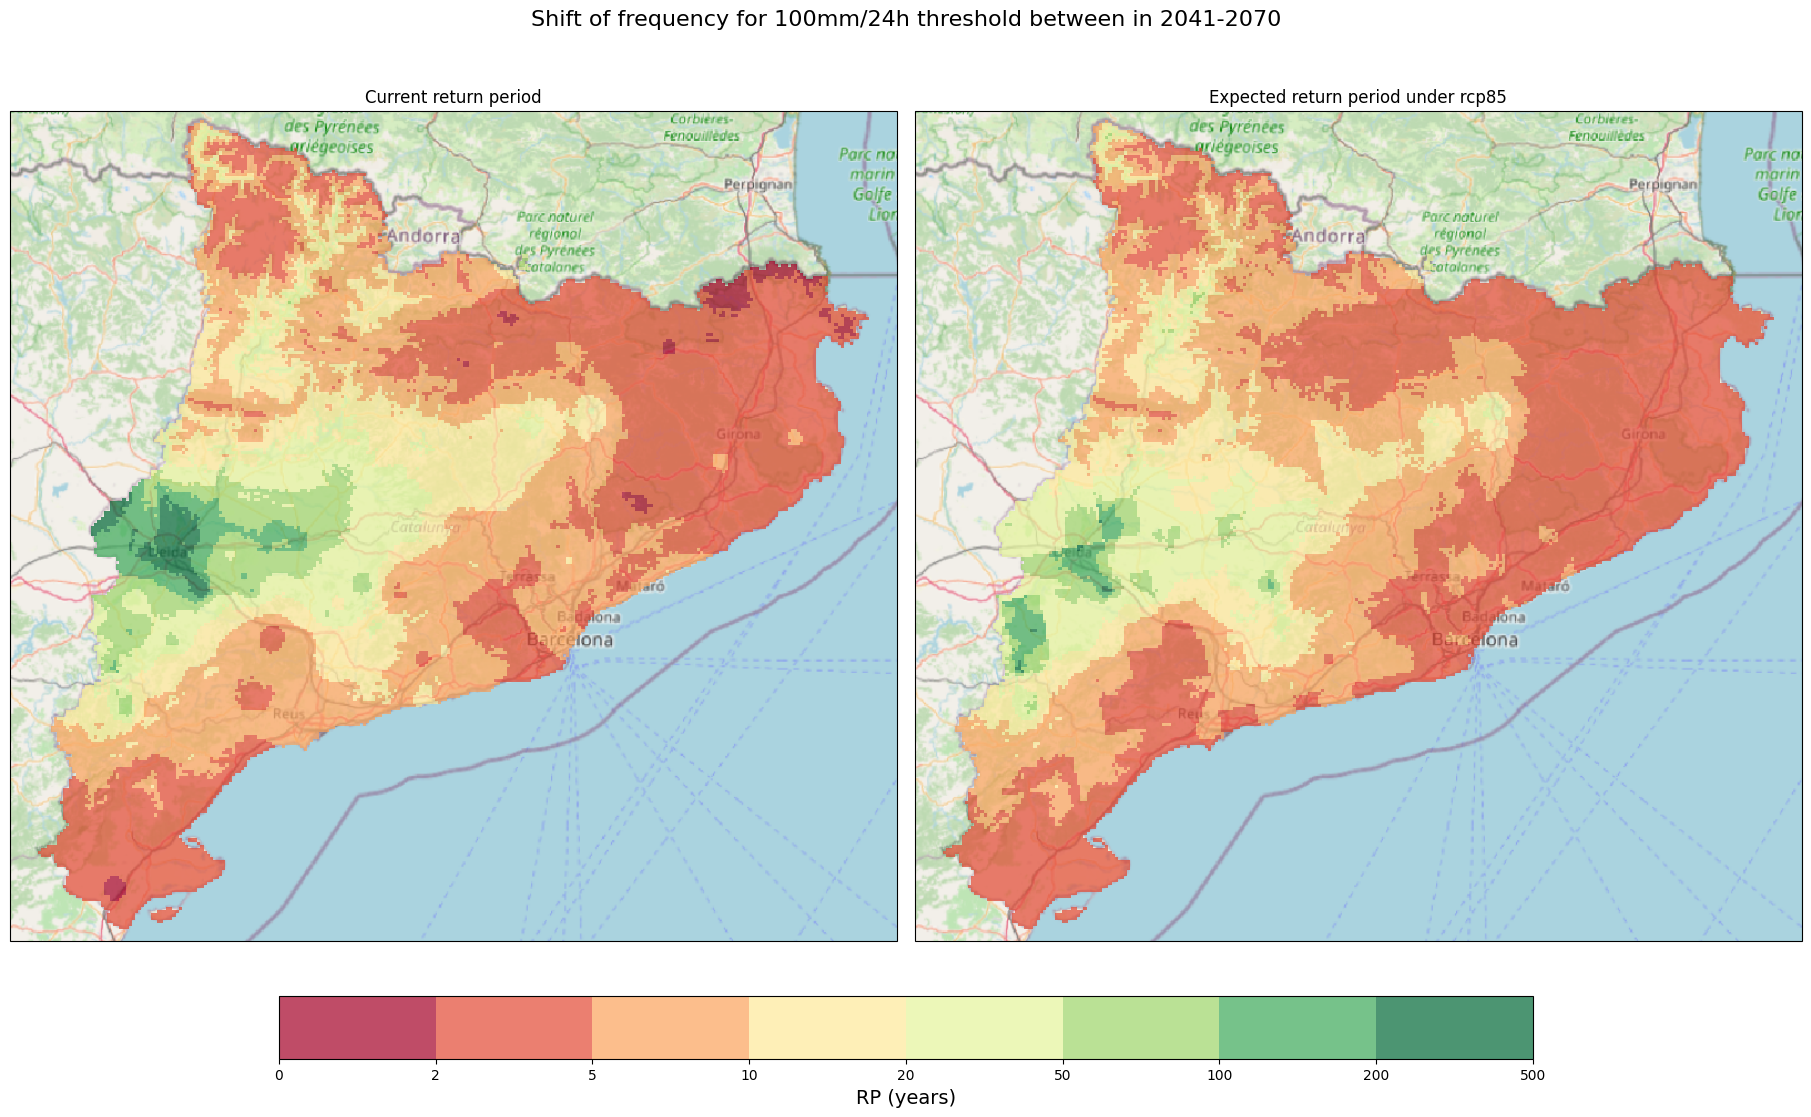

In [18]:
# Convert projection so matplotlib understands it.
proj_rp_map = ccrs.epsg(proj_rp_th.to_epsg())
# Path of rasters to plot.
r1 = path_rp_th
r2 = glob.glob(os.path.join(results_dir, 'RP_shift*.tiff'))[0]
# Define colorbar.
cmap_ret_per = plt.get_cmap("RdYlGn")
bounds_ret_per = [0, 2, 5, 10, 20, 50, 100, 200, 500]
norm_ret_per = mpl.colors.BoundaryNorm(bounds_ret_per, cmap_ret_per.N)
fig_rp, ax_rp = plt.subplots(1,2, figsize = (18,11), subplot_kw = {'projection': proj_rp_map}, layout = 'constrained')
for i, file in enumerate([r1, r2]):
    ds_i = rio.open_rasterio(file, masked =True)
    im = ds_i.plot(ax = ax_rp[i], add_colorbar=False, norm = norm_ret_per, cmap=cmap_ret_per, alpha = 0.7)
    ctx.add_basemap(ax=ax_rp[i], crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik,
               attribution = False)

ax_rp[0].set_title('Current return period')
ax_rp[1].set_title(f'Expected return period under {RCP}')
cb_rp = fig_rp.colorbar(im, ax = ax_rp[:], ticks=bounds_ret_per, location='bottom', shrink = 0.7)
cb_rp.set_label('RP (years)', fontsize = 14)
fig_rp.suptitle(f"Shift of frequency for 100mm/24h threshold between in {TIME_FRAMES[RCP]}",fontsize = 16)
plt.show()

fig_rp.savefig(os.path.join(plots_dir, f'RP_shift_threshold_{TIME_FRAMES[RCP]}.png'))

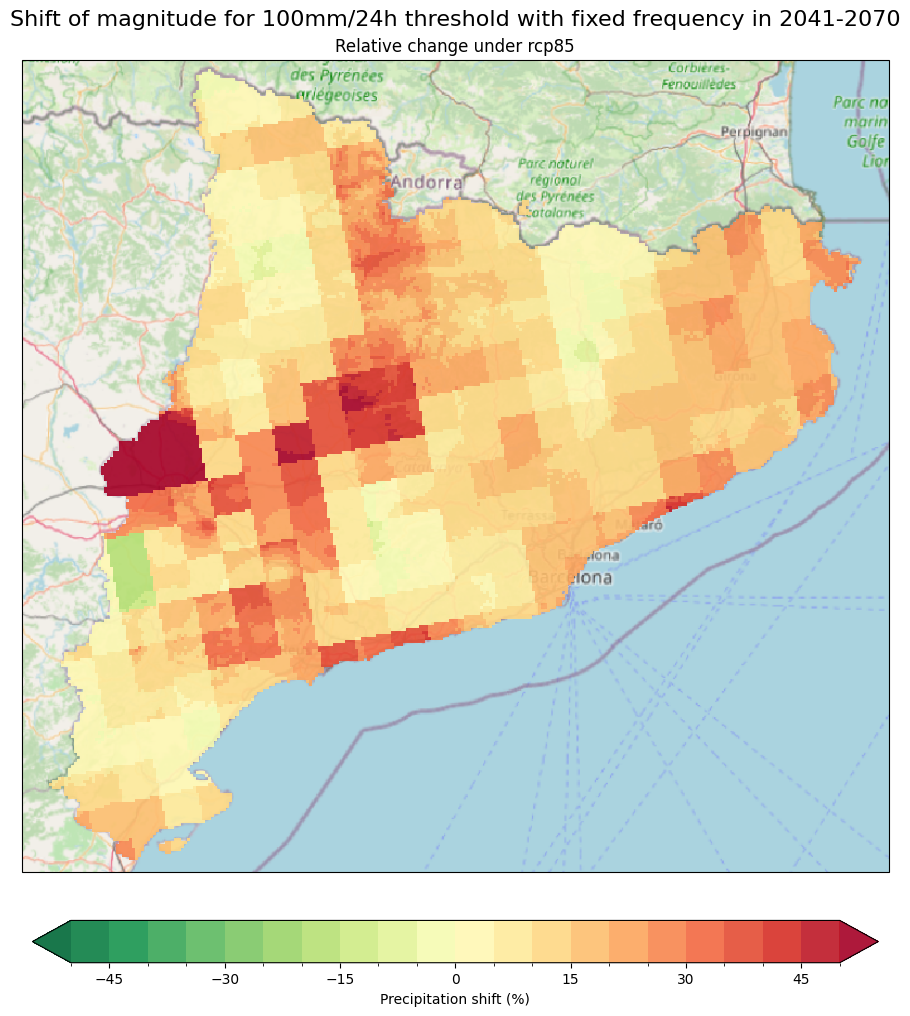

In [24]:
# Path of rasters to plot.
r4 = os.path.join(results_dir, f"PREC_factor_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff")

# Define colormap for absolute values and relative change
cmap_rel = plt.get_cmap("RdYlGn_r")
relative_bounds = np.arange(-50, 55, 5)
norm_rel = mpl.colors.BoundaryNorm(relative_bounds, cmap_rel.N, extend='both')


fig, ax = plt.subplots(figsize = (17,10), subplot_kw = {'projection': proj_rp_map}, layout = 'constrained')

ds_rel = rio.open_rasterio(r4, masked =True)
ds_rel = (ds_rel-1)*100

# TODO: ESBORRAR!
filename_factor = f"shift_magnitude_100mm-24h_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"

write_geotiff(filename_factor, ds_rel[0,:,:])
# FI TODO

im_rel = ds_rel.plot(ax = ax, add_colorbar=False, norm = norm_rel, cmap=cmap_rel, alpha = 0.9)
cb_rel = fig.colorbar(im_rel, ax = ax, location ='bottom', shrink = 0.5 )
cb_rel.set_label('Precipitation shift (%)')
ctx.add_basemap(ax=ax, crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik,
               attribution = False)

ax.set_title(f'Relative change under {RCP}')
fig.suptitle(f'Shift of magnitude for 100mm/24h threshold with fixed frequency in {TIME_FRAMES[RCP]}',fontsize = 16)
plt.show()
fig.savefig(os.path.join(plots_dir, f'PREC_shift_threshold_{TIME_FRAMES[RCP]}.png'))

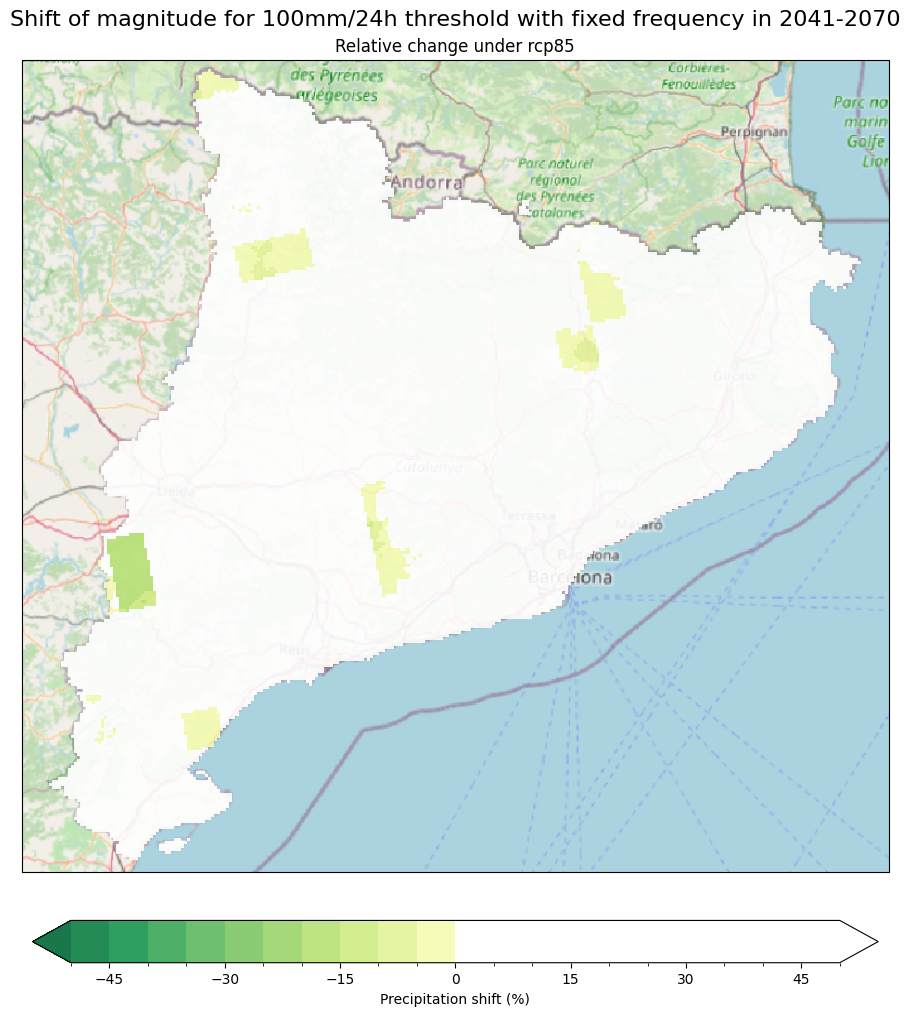

In [19]:
# Path of rasters to plot.
r4 = os.path.join(results_dir, f"PREC_factor_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff")

# Define custom colormap for values (the negative values in green-yellow, all the positive values white)
cmap_rel = mpl.colors.ListedColormap(plt.get_cmap("RdYlGn_r")(np.linspace(0, 1, 256)))
cmap_rel.colors[128:] = [1, 1, 1, 1]  # Set the second half of colormap (0 and positive values) to white

# Define new boundaries and normalization for the colormap
relative_bounds = np.arange(-50, 55, 5)
norm_rel = mpl.colors.BoundaryNorm(relative_bounds, cmap_rel.N, extend='both')

fig, ax = plt.subplots(figsize=(17, 10), subplot_kw={'projection': proj_rp_map}, layout='constrained')

# Read raster data
ds_rel = rio.open_rasterio(r4, masked=True)
ds_rel = (ds_rel - 1) * 100

# Plot the data with the modified norm and colormap
im_rel = ds_rel.plot(ax=ax, add_colorbar=False, norm=norm_rel, cmap=cmap_rel, alpha=0.9)
cb_rel = fig.colorbar(im_rel, ax=ax, location='bottom', shrink=0.5)
cb_rel.set_label('Precipitation shift (%)')

# Add basemap and set titles
ctx.add_basemap(ax=ax, crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik, attribution=False)
ax.set_title(f'Relative change under {RCP}')
fig.suptitle(f'Shift of magnitude for 100mm/24h threshold with fixed frequency in {TIME_FRAMES[RCP]}', fontsize=16)

# Show and save the plot
plt.show()
fig.savefig(os.path.join(plots_dir, f'PREC_shift_threshold_neg_{TIME_FRAMES[RCP]}.png'))


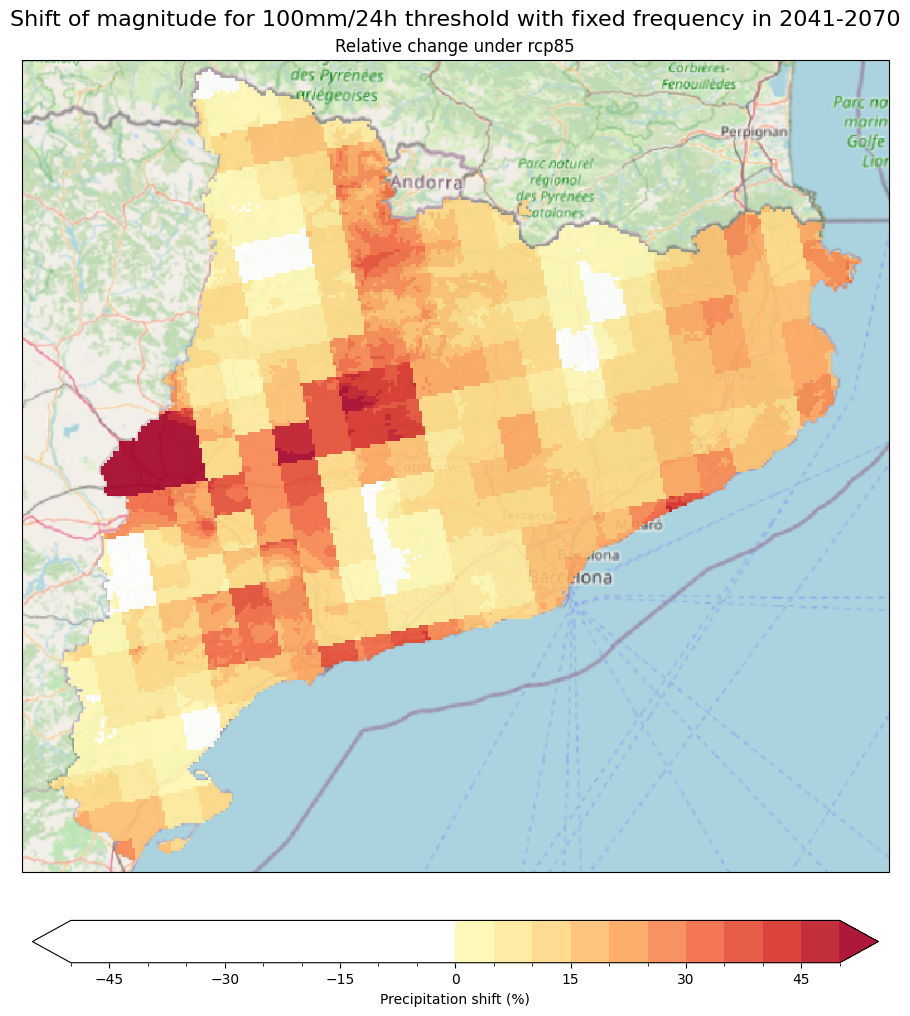

In [20]:
# Path of rasters to plot.
r4 = os.path.join(results_dir, f"PREC_factor_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff")

# Define custom colormap for values (the negative values in green-yellow, all the positive values white)
cmap_rel = mpl.colors.ListedColormap(plt.get_cmap("RdYlGn_r")(np.linspace(0, 1, 256)))
cmap_rel.colors[:128] = [1, 1, 1, 1]  # Set the second half of colormap (0 and positive values) to white

# Define new boundaries and normalization for the colormap
relative_bounds = np.arange(-50, 55, 5)
norm_rel = mpl.colors.BoundaryNorm(relative_bounds, cmap_rel.N, extend='both')


fig, ax = plt.subplots(figsize = (17,10), subplot_kw = {'projection': proj_rp_map}, layout = 'constrained')

ds_rel = rio.open_rasterio(r4, masked =True)
ds_rel = (ds_rel-1)*100
ds_rel.values = ds_rel.values
im_rel = ds_rel.plot(ax = ax, add_colorbar=False, norm = norm_rel, cmap=cmap_rel, alpha = 0.9)
cb_rel = fig.colorbar(im_rel, ax = ax, location ='bottom', shrink = 0.5 )
cb_rel.set_label('Precipitation shift (%)')
ctx.add_basemap(ax=ax, crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik,
               attribution = False)

ax.set_title(f'Relative change under {RCP}')
fig.suptitle(f'Shift of magnitude for 100mm/24h threshold with fixed frequency in {TIME_FRAMES[RCP]}',fontsize = 16)
plt.show()
fig.savefig(os.path.join(plots_dir, f'PREC_shift_threshold_pos_{TIME_FRAMES[RCP]}.png'))

## Example 2: More to come! Keep an eye on this section for new updates and examples

## Authors
The Center of Applied Research in Hydrometrology from the Universitat Politècnica de Catalunya (CRAHI-UPC). The members involved in the development of this workflow were the following:

Erika R. Meléndez-Landaverde<br> 
Víctor González<br>
Marta Gabarró Solanas<br>
Daniel Sempere-Torres